In [31]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from random import seed
from random import random

In [32]:
# This funtion generates data 
def data_generator(n):
    As = []    
    x = np.random.normal(0,1,size = (n,2)) # n is the size of sample
    noise = np.random.normal(0,0.04**2) 
    
    for condition_number in [1,0.1,0.01,0.001]: # create a list of As with different conditional number
        A = np.matrix([[1, 1], [1, 1+condition_number]])
        As.append(A)
        
    y1 = np.dot(x,As[0]) + 0.01*noise #compute y with different A
    y01 = np.dot(x,As[1]) + 0.01*noise
    y001 = np.dot(x,As[2]) + 0.01*noise
    y0001 = np.dot(x,As[3]) + 0.01*noise
    
    x = torch.Tensor(x).float() #convert all ndarrays to tensors
    y1 = torch.Tensor(y1).float()
    y01 = torch.Tensor(y01).float()
    y001 = torch.Tensor(y001).float()
    y0001 = torch.Tensor(y0001).float()
       
    return x, y1, y01, y001, y0001    

In [33]:
#set up weight for the first layer
w1 = w11 = random()
w3 = -w11
w2 = w12 = random()
w4  = -w12
w5 = w21 = random()
w7 = -w21
w6 = w22 = random()
w8 = -w22

K1 = torch.Tensor([[w1,w2],[w3,w4],[w5,w6],[w7,w8]])

#set up weights for the second layer
K2 = torch.Tensor([[1,-1,0,0],[0,0,1,-1]])

# print(K1.shape,'\n')
# print(K2.shape)
# print (w1,w3,w2,w4,w5,w7,w6,w8)

In [34]:
# Define the network structure
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4) #initializing nodes
        self.fc1.weight.data = K1 #initializing weights       
        print("fc1 weight:",self.fc1.weight.data)
        nn.init.zeros_(self.fc1.bias) #initializing bias to zeros


        self.fc2 = nn.Linear(4, 2) 
        self.fc2.weight.data = K2
        print("fc2 weight:",self.fc2.weight.data)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        hidden = F.relu(self.fc1(x)) #apply the Relu activation function
        output = self.fc2(hidden)
        return output

model = NN()
model = model.float()
criterion = nn.MSELoss() #uses MSE function from sikit learn to calculate the loss
optimizer = optim.SGD(model.parameters(), lr=0.001) #SGD = Stochastic Gradient Decscent, lr = learning rate

fc1 weight: tensor([[ 0.2443,  0.0567],
        [-0.2443, -0.0567],
        [ 0.2659,  0.0218],
        [-0.2659, -0.0218]])
fc2 weight: tensor([[ 1., -1.,  0.,  0.],
        [ 0.,  0.,  1., -1.]])


In [35]:
# use this function to run the neural network
def run_net(train_x,train_y,epochs): 
    epochs = epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_ll = [] 
    batch_size = len(train_x) # set batch size to the length of data
    model.to(device)

    for epoch in range(epochs):
        permutation = torch.randperm(train_x.size()[0])
        for i in range(0, train_x.size()[0],batch_size):
            
            optimizer.zero_grad() 
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = train_x[indices], train_y[indices] 
            
            outputs = model.forward(batch_x)  #feed the train x to get prediction      
            loss = criterion(outputs,batch_y)  #compare the prediction, train y and get the loss
            train_ll.append(loss)
            loss.backward() #do back propagation
            optimizer.step() #update the weights
            
    return train_ll 


#             print(f"Epoch {epoch+1}/{epochs}.. "
#                   f"Train loss: {loss:.3f}.. ")

In [36]:
def main(n,epochs):
    

    train_x_all, train_y_1,train_y_01,train_y_001,train_y_0001= data_generator(n) # fetch the data 
    
    list_1 = run_net(train_x_all,train_y_1,epochs) #collecting the loss and put them in to according list
    list_01 = run_net(train_x_all,train_y_01,epochs)
    list_001 = run_net(train_x_all,train_y_001,epochs)
    list_0001 = run_net(train_x_all,train_y_0001,epochs)        
    
    # plot 3000 epochs and the losses
    epochs = 3000
    plt.suptitle('Forward Problem')
    plt.plot(range(epochs),list_1)
    plt.plot(range(epochs),list_01)
    plt.plot(range(epochs),list_001)
    plt.plot(range(epochs),list_0001)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,0.1))
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend(['1', '0.1', '0.01', '0.001'], loc='upper right')
    plt.show()

    # plot the first 1000 epochs
    epochs = 1000
    plt.suptitle('Forward Problem')
    plt.plot(range(epochs),list_1[:1000])
    plt.plot(range(epochs),list_01[:1000])
    plt.plot(range(epochs),list_001[:1000])
    plt.plot(range(epochs),list_0001[:1000])
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,0.1))
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend(['1', '0.1', '0.01', '0.001'], loc='upper right')
    plt.show()

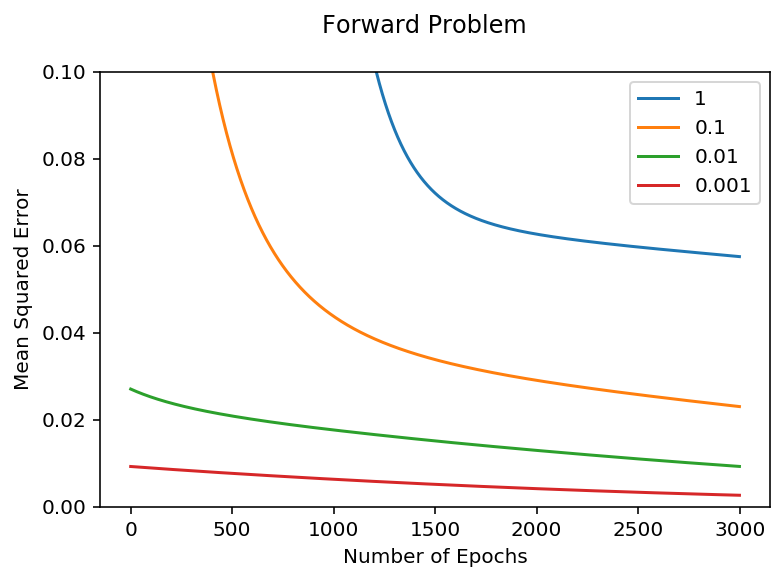

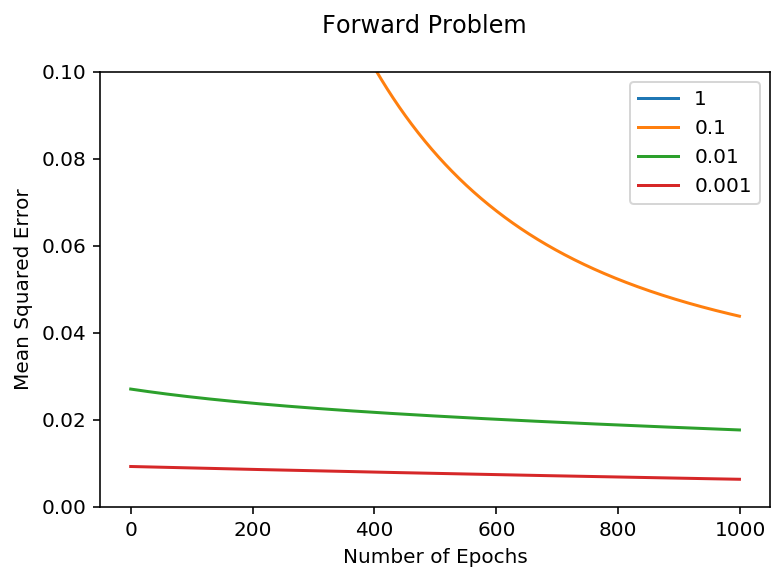

In [37]:
# To use the forward net, use the function below
main(10000,3000) #main(number of samples, number of epochs)